<a href="https://colab.research.google.com/github/zmasoomi/zeinab_masoomi/blob/main/forecasting_close_value_of_stock_market.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In this project, a regression model will be Created using the PyTorch framework to predict the closing price of a stock. The dataset named *"train.csv"* contains stock prices. This data set includes information such as **the opening price, the lowest price of the day, the highest price of the day and the closing price on certain days, as well as the trading volume of the stock**.

The goal is to train a model that accurately predicts the closing price.

This task follows these steps:

1. Do your task on Google Colab.
2. Implement a regression model using the PyTorch framework. You can use different architectures, models and algorithms based on your experience and experiments.
3. Evaluate your model using the root mean square error (RMSE) measure.

In [ ]:
pip install pmdarima#installing library for ARIMA

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime, date

import torch
import torch.nn as nn
import torch.optim as optim


from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.statespace.tools import diff
from statsmodels.tsa.seasonal import seasonal_decompose
from pmdarima import auto_arima
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.arima_model import ARIMA

from sklearn.model_selection import train_test_split
from statsmodels.tools.eval_measures import rmse
from sklearn.metrics import mean_squared_error


In [ ]:
class DataLoaderPipeline:
    def __init__(self):
        # self.file_path = file_path
        self.data = None
        self.file_name = None

    def load_data(self):
        # Mount Google Drive
        # drive.mount('/content/drive')
        from google.colab import files
        self.uploaded = files.upload()
        self.file_name = next(iter(self.uploaded)).split('/')[-1]

        # Load data from the specified file path
        try:
            self.data = pd.read_csv(self.file_name)
            self.data = pd.DataFrame(self.data)
            data_loader.data.copy()
            print("Data loaded successfully!")
        except Exception as e:
            print(f"Error loading data: {e}")

    def show_data_summary(self):
        if self.data is not None:
            print(self.data.head())  # Display the first few rows of the loaded data

        else:
            print("No data loaded yet. Use load_data() to load data first.")

    def info(self):
      print(self.data.info())


# # Example usage:
# file_path = '/content/drive/My Drive/data/time_series_data.csv'

# Instantiate the DataLoaderPipeline class
data_loader = DataLoaderPipeline()

In [ ]:
# Load data
data_loader.load_data()

# # Show summary of the loaded data
data_loader.show_data_summary()

Saving train.csv to train (9).csv
Data loaded successfully!
         Date       Open       High        Low     Volume      Close
0  14-08-2015  57.484790  58.398406  57.342469  171718000  58.237720
1  17-08-2015  58.274453  59.013611  58.026536  163538800  58.788651
2  18-08-2015  58.453501  58.917197  58.260678  138242800  58.485638
3  19-08-2015  58.301997  58.494820  57.650069  193146000  57.801575
4  20-08-2015  57.374601  57.498558  56.249794  274006400  56.718082


In [ ]:
train = data_loader.data.copy()

In [ ]:
train.columns


Index(['Date', 'Open', 'High', 'Low', 'Volume', 'Close'], dtype='object')

In [ ]:
train.Date = pd.to_datetime(train.Date)#converting to date format
train = train.set_index('Date')

<ipython-input-54-1b5e2dd8ef3e>:1: UserWarning: Parsing dates in DD/MM/YYYY format when dayfirst=False (the default) was specified. This may lead to inconsistently parsed dates! Specify a format to ensure consistent parsing.
  train.Date = pd.to_datetime(train.Date)#converting to date format


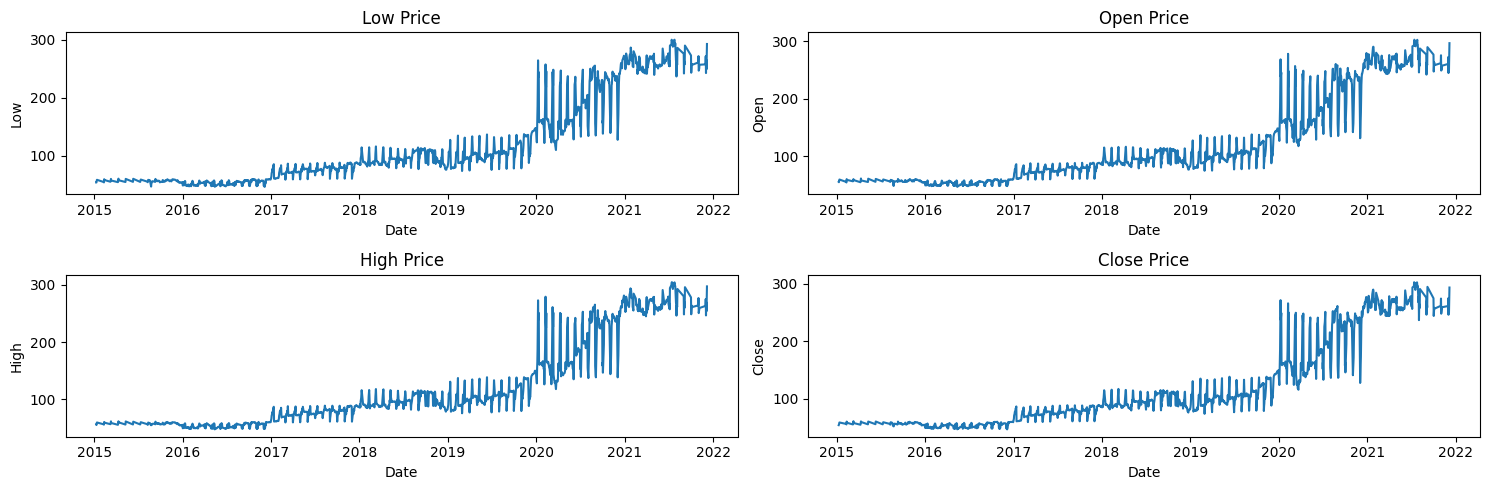

In [ ]:
#plotting data to see stationary and seasonality in data
fig, axs = plt.subplots(2,2, figsize=(15, 5))
sns.lineplot(train.Low, ax=axs[0, 0])
axs[0, 0].set_title('Low Price')
sns.lineplot(train.High, ax=axs[1, 0])
axs[1, 0].set_title('High Price')
sns.lineplot(train.Open, ax=axs[0, 1])
axs[0, 1].set_title('Open Price')
sns.lineplot(train.Close, ax=axs[1, 1])
axs[1, 1].set_title('Close Price')
plt.tight_layout()

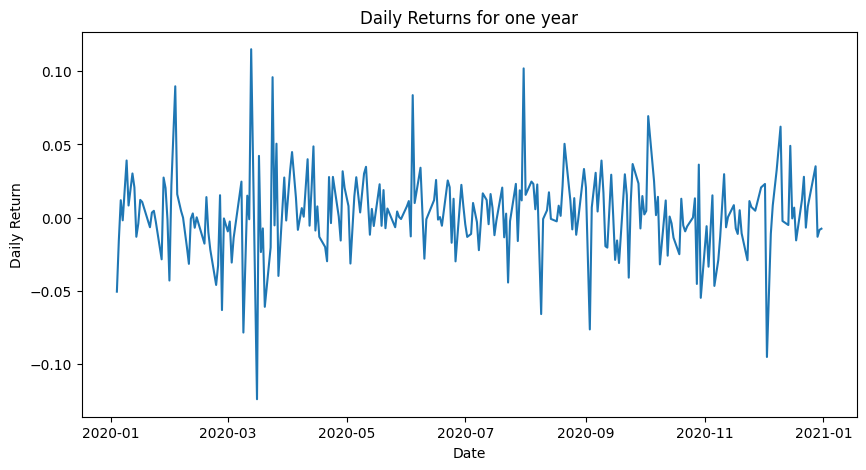

In [ ]:
# Calculate daily returns based on the 'Close' column
train['Daily_Return'] = train['Close'].pct_change()  # Calculate daily returns

# Drop the first row (NaN due to no previous value for the first day)
train.dropna(subset=['Daily_Return'], inplace=True)

# Plotting daily returns
plt.figure(figsize=(10, 5))
sns.lineplot(train['Daily_Return'][train.index.year==2020])#splitting for 2020 to see precisily the detail of daily return behaviour
plt.title('Daily Returns for one year')
plt.xlabel('Date')
plt.ylabel('Daily Return')
plt.show()


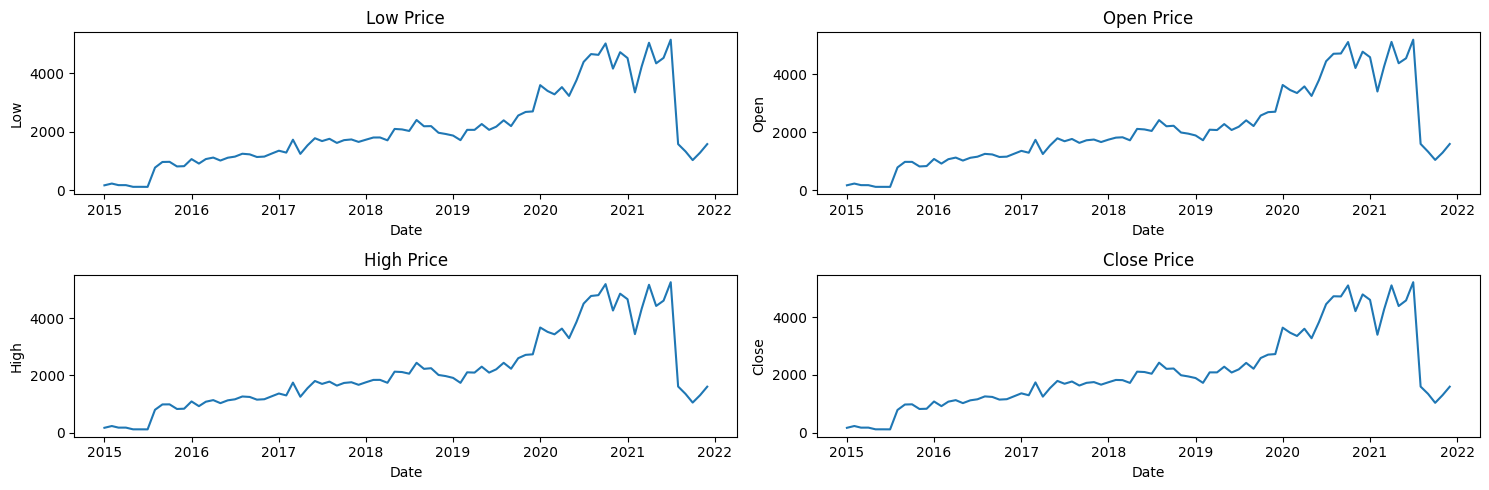

In [ ]:
#extracting month and year from date column
train['Month'] = train.index.month
train['Year'] = train.index.year


train_grouped_date = train.groupby(['Year', 'Month']).sum().reset_index()#to group data on year and month to analyze time series
# train_grouped_date.head()


#to make a date format as YYYY-M-01
train_grouped_date['Day'] = 1
train_grouped_date['Date'] = pd.to_datetime(train_grouped_date[['Year', 'Month', 'Day']], format='%Y-%m-01')
# train_grouped_date


#picking necessary columns for timeseries analyzing
new_train = train_grouped_date[['Open', 'High', 'Low', 'Volume', 'Close','Date']]

new_train.index.freq = 'M'#to have frequency on month
new_train.set_index('Date', inplace=True)



#plotting grouped data after date column revising
fig, axs = plt.subplots(2,2, figsize=(15, 5))
sns.lineplot(new_train.Low, ax=axs[0, 0])
axs[0, 0].set_title('Low Price')
sns.lineplot(new_train.High, ax=axs[1, 0])
axs[1, 0].set_title('High Price')
sns.lineplot(new_train.Open, ax=axs[0, 1])
axs[0, 1].set_title('Open Price')
sns.lineplot(new_train.Close, ax=axs[1, 1])
axs[1, 1].set_title('Close Price')
plt.tight_layout()

Based on the plots, there are non stationary and seasonality. Then we should to test them by available evaluations tests to approve it. Using a non-stationary time series could lead to spurious results, wrongly implying cause & effect between two variables--thus rendering our results uninterpretable. So to test stationary, it should be used ACF test and for seasonlity, ADF test. Augmented Dickey-Fuller (ADF) Test:

***The Augmented Dickey-Fuller Test is a type of unit root test that helps us determine if our time series data is stationary or not.**

***Null Hypothesis: The series has a unit root (is NOT stationary).**

***Alternate Hypothesis: The series has no unit root (is stationary)**

***Conditions for Rejecting Null Hypothesis: p-value < 0.05 and Test Statistic < Critical Value.**


In [ ]:
#defining a function to have Dickey-Fuller Test as a stationary test
def adf_test(timeseries):

    for col in timeseries.columns:
        print(f"Results of Dickey-Fuller Test of {col}:",  )
        print('\n')
        dftest = adfuller(timeseries[col], autolag="AIC")
        dfoutput = pd.Series(
            dftest[0:4],
            index=[
                "Test Statistic",
                "p-value",
                "#Lags Used",
                "Number of Observations Used",
            ],
        )

        for key, value in dftest[4].items():
            dfoutput["Critical Value (%s)" % key] = value
        print(dfoutput)
        print('\n')

        if dfoutput['p-value'] < 0.05:
            print('Strong evidence against the null hypothesis')
            print('We reject the null hypothesis')
            print('Series has no unit root & is stationary')
        else:
            print('Weak evidence against the null hypothesis')
            print('We fail to reject the null hypothesis')
            print('Series has unit root and is non-stationary')

        plot_acf(timeseries[col])
        # Shaded region represents 95% CI
        # Correlation values outside of this CI very likely to be correlations
        # In this case, our 'spikes' are mostly found within the blue zone
        # our order for q would be 0
        print('********************************************************')

The ADF test shows whether or not non stationary timeseries is. Therefore, diff model as differenc will be used to remove stationary and seasonality from data.

Results of Dickey-Fuller Test of Close:


Test Statistic                    1.346518
p-value                           0.996857
#Lags Used                       24.000000
Number of Observations Used    1474.000000
Critical Value (1%)              -3.434794
Critical Value (5%)              -2.863503
Critical Value (10%)             -2.567815
dtype: float64


Weak evidence against the null hypothesis
We fail to reject the null hypothesis
Series has unit root and is non-stationary
********************************************************
Results of Dickey-Fuller Test of Open:


Test Statistic                    1.450954
p-value                           0.997334
#Lags Used                        2.000000
Number of Observations Used    1496.000000
Critical Value (1%)              -3.434729
Critical Value (5%)              -2.863474
Critical Value (10%)             -2.567800
dtype: float64


Weak evidence against the null hypothesis
We fail to reject the null hypothesis
Series has unit root 

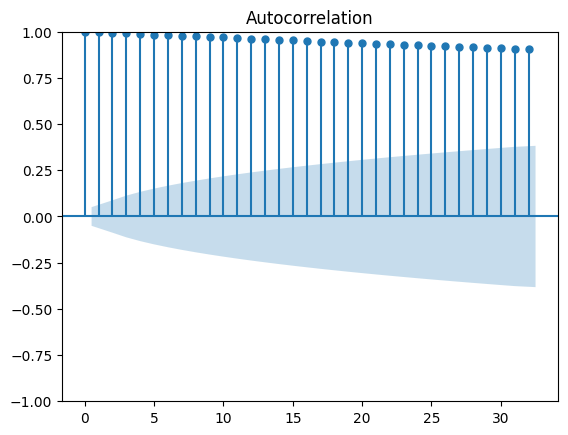

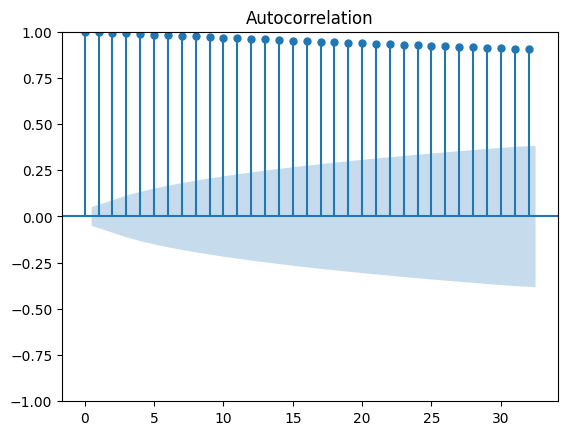

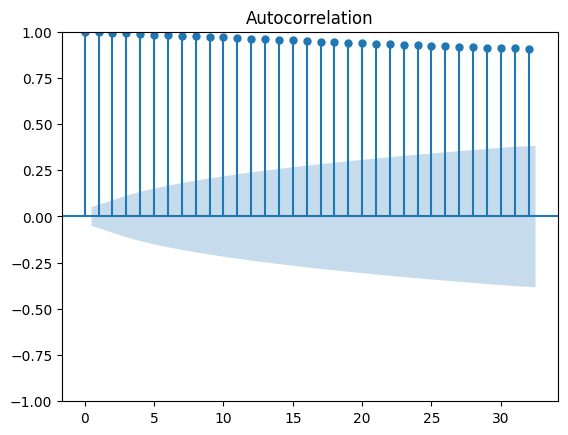

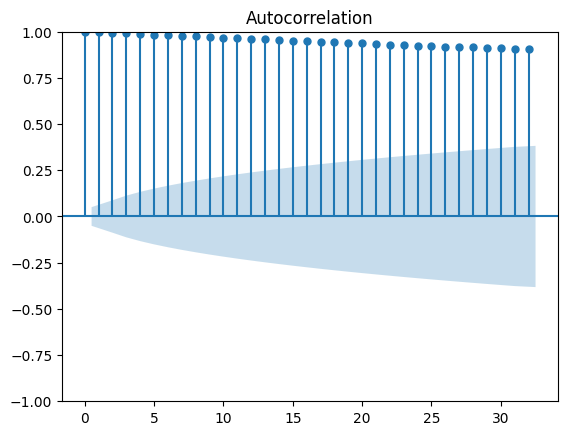

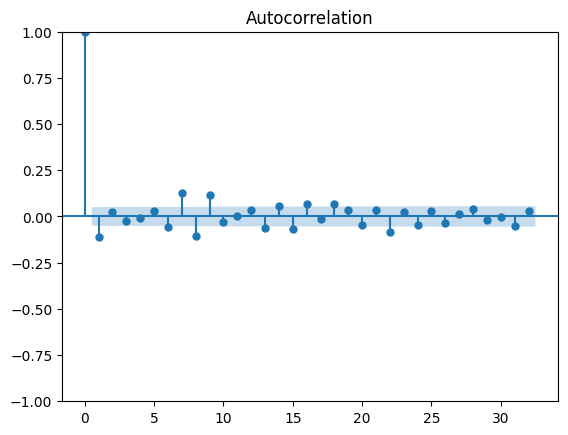

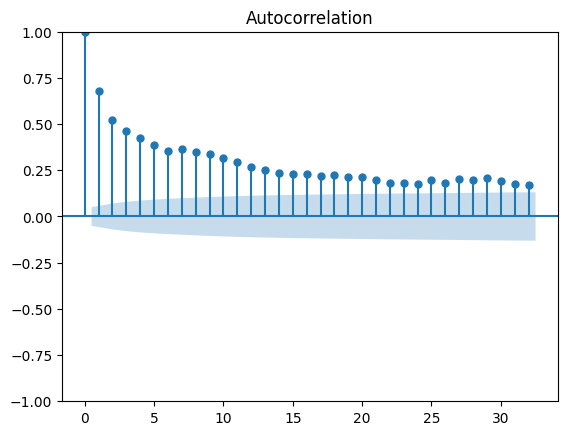

In [ ]:
adf_test(train[['Close', 'Open', 'High', 'Low', 'Daily_Return', 'Volume']])#performing function on train data

Results of Dickey-Fuller Test of Close:


Test Statistic                 -2.970725
p-value                         0.037720
#Lags Used                     11.000000
Number of Observations Used    72.000000
Critical Value (1%)            -3.524624
Critical Value (5%)            -2.902607
Critical Value (10%)           -2.588679
dtype: float64


Strong evidence against the null hypothesis
We reject the null hypothesis
Series has no unit root & is stationary
********************************************************
Results of Dickey-Fuller Test of Open:


Test Statistic                 -2.957741
p-value                         0.039034
#Lags Used                     11.000000
Number of Observations Used    72.000000
Critical Value (1%)            -3.524624
Critical Value (5%)            -2.902607
Critical Value (10%)           -2.588679
dtype: float64


Strong evidence against the null hypothesis
We reject the null hypothesis
Series has no unit root & is stationary
************************

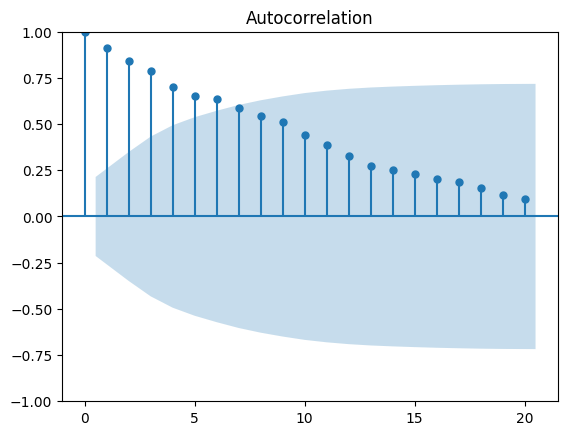

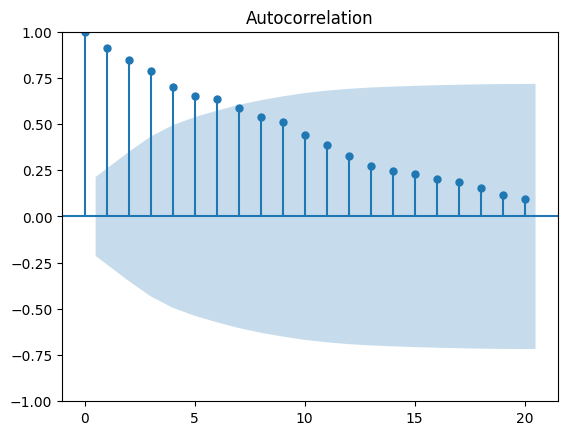

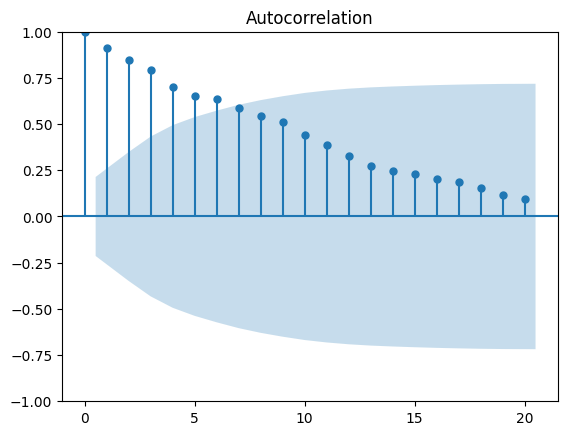

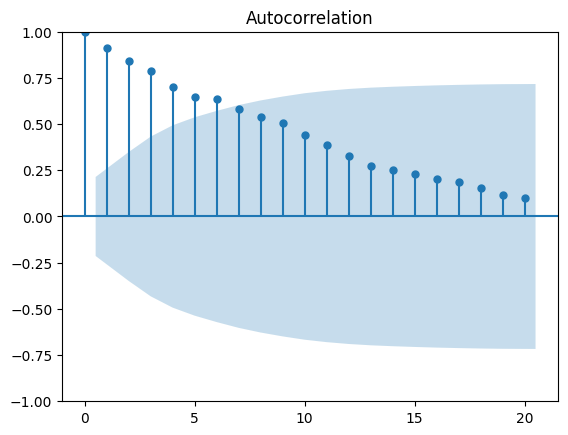

In [ ]:
adf_test(train_grouped_date[['Close', 'Open', 'High', 'Low']])

In [ ]:
#despite higher p-value approving nonstationary series, train data has been chosen,
#because of overfitting of other data such as grouped data and new train dataset.
#we need complexity for this model.

#The loss is low enough and it is satisfying to have a good prediction and forecast
#well as shows clearly by having mean on test and prediction, however, there is
#no preprocessing on data to remove stationary and seasonality.


# Split the data into features (x) and target variable (y)
x =train[['Low', 'High', 'Open']]# Input features
y = train['Close'] # Target variable

x_tensor = torch.tensor(x.values, dtype=torch.float32)
y_tensor = torch.tensor(y.values, dtype=torch.float32).unsqueeze(1)  # Ensure shape is (N, 1) for regression

# Split the data into train and test sets
x_train, x_test, y_train, y_test = train_test_split(x_tensor, y_tensor, test_size=0.2, shuffle=False)

In [ ]:
#defined a class to do regression in pytorch with train data
class StockPredictionModel(nn.Module):
    def __init__(self, input_size, output_size):
        super(StockPredictionModel, self).__init__()
        self.fc1 = nn.Linear(input_size, 10)
        self.fc2 = nn.Linear(10, output_size)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x

# Initialize the model
input_size = x_train.shape[1]  # Number of input features
output_size = 1  # One output (for regression)
model = StockPredictionModel(input_size, output_size)

# Define loss function and optimizer
criterion = nn.MSELoss()  # Mean Squared Error loss
optimizer = optim.Adam(model.parameters(), lr=0.01)  # Stochastic Gradient Descent optimizer

# Training the model
num_epochs = 200
for epoch in range(num_epochs):
    # Forward pass
    optimizer.zero_grad()
    outputs = model(x_train)
    loss = criterion(outputs, y_train)
    loss.backward()
    optimizer.step()
    if (epoch + 1) % 10 == 0:
        print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {loss.item():.4f}')

# Prediction on test set
with torch.no_grad():
    predicted = model(x_test)
    test_loss = criterion(predicted, y_test)
    test_rmse = torch.sqrt(test_loss)
    print(f'Test RMSE: {test_rmse.item():.4f}')

Epoch [10/200], Loss: 5670.5923
Epoch [20/200], Loss: 1713.1270
Epoch [30/200], Loss: 17.3386
Epoch [40/200], Loss: 214.0339
Epoch [50/200], Loss: 29.9522
Epoch [60/200], Loss: 16.5148
Epoch [70/200], Loss: 9.1507
Epoch [80/200], Loss: 1.6383
Epoch [90/200], Loss: 1.9168
Epoch [100/200], Loss: 0.7981
Epoch [110/200], Loss: 0.8198
Epoch [120/200], Loss: 0.7007
Epoch [130/200], Loss: 0.6865
Epoch [140/200], Loss: 0.6806
Epoch [150/200], Loss: 0.6746
Epoch [160/200], Loss: 0.6753
Epoch [170/200], Loss: 0.6742
Epoch [180/200], Loss: 0.6743
Epoch [190/200], Loss: 0.6741
Epoch [200/200], Loss: 0.6741
Test RMSE: 2.4948


##Prediction

Root Mean Squared Error (RMSE): 2.4948
Prediction mean: 243.4461, Ground truth mean:  243.6221


/usr/local/lib/python3.10/dist-packages/numpy/core/shape_base.py:65: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  ary = asanyarray(ary)
/usr/local/lib/python3.10/dist-packages/numpy/core/shape_base.py:65: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ary = asanyarray(ary)


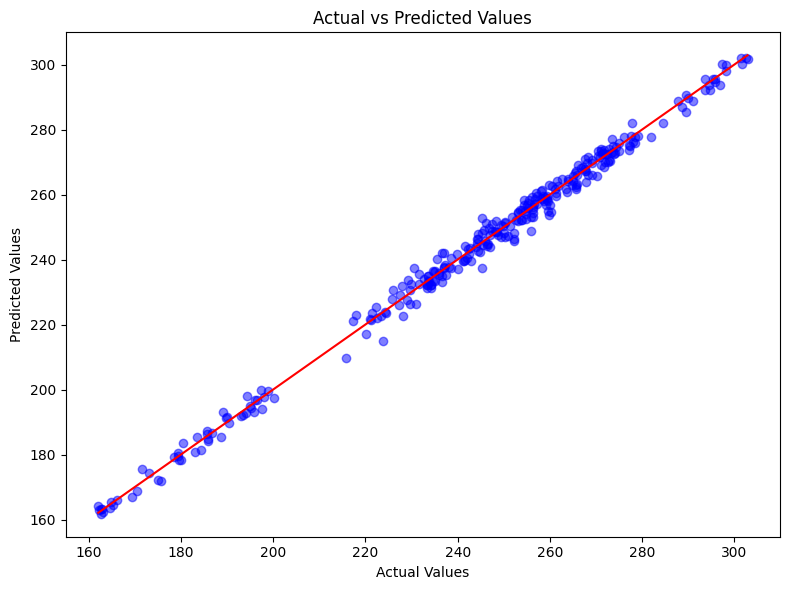

In [ ]:
# Prediction on test set
with torch.no_grad():
    predicted = model(x_test)

# Convert PyTorch tensors to numpy arrays
predicted = predicted.numpy()
# y_test = y_test.numpy()

# Calculate RMSE
rmse = np.sqrt(mean_squared_error(y_test, predicted))
# rmse= rmse(y_test, predicted)
print(f'Root Mean Squared Error (RMSE): {rmse:.4f}')
print(f'Prediction mean: {predicted.mean():.4f}, Ground truth mean:  {y_test.mean():.4f}')


#Plotting prediction data and y_test
plt.figure(figsize=(8, 6))
plt.scatter(y_test, predicted, color='blue', alpha=0.5)
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Actual vs Predicted Values')
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red')  #  for reference
plt.tight_layout()
plt.show()

Based on the visualization above, actual value and predicted value are close and the loss value approves it as well. Therefore, we can forecast through test data below which has never trained by model.

## forecasting

In [ ]:
#Loading test data
test_loader = DataLoaderPipeline()
test_loader.load_data()
test_loader.show_data_summary()
test_data = test_loader.data.copy()


#convert column of Date to datetime format
test_data.Date = pd.to_datetime(test_data.Date)
test_data = test_data.set_index('Date')


#converting test data to tensor to use in torch
x_test_data = test_data[['Low', 'High', 'Open']]
test_tensor = torch.tensor(x_test_data.values, dtype=torch.float32)
with torch.no_grad():
    predicted_test = model(test_tensor)

# Convert PyTorch tensors to numpy arrays
predicted_test = predicted_test.numpy()
print('~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~Predicted Close Price~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ ')
predicted_test

Saving test.csv to test (2).csv
Error loading data: 'NoneType' object has no attribute 'copy'
         Date        Open        High         Low    Volume  Close
0  30-07-2021  293.328006  297.222166  292.788806  70382000    NaN
1  02-08-2021  297.282094  298.460321  295.065414  62880000    NaN
2  03-08-2021  296.183715  300.637034  294.925590  64786600    NaN
3  04-08-2021  299.099384  300.137807  297.122335  56368300    NaN
4  05-08-2021  298.520228  300.237657  296.902657  46397700    NaN
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~Predicted Close Price~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ 


<ipython-input-78-c71725a3ac8b>:9: UserWarning: Parsing dates in DD/MM/YYYY format when dayfirst=False (the default) was specified. This may lead to inconsistently parsed dates! Specify a format to ensure consistent parsing.
  test_data.Date = pd.to_datetime(test_data.Date)


array([[294.70413],
       [297.06726],
       [297.38638],
       [298.95953],
       [298.75018],
       [297.9552 ],
       [297.5399 ],
       [298.03644],
       [297.49152],
       [299.2219 ],
       [303.0501 ],
       [302.16995],
       [305.73172],
       [302.17407],
       [296.79272],
       [300.37143],
       [302.82407],
       [304.9444 ],
       [303.51108],
       [301.85205],
       [300.5846 ],
       [305.7699 ],
       [309.60852],
       [311.96765],
       [312.35425],
       [312.90585],
       [316.24988],
       [316.66354],
       [315.39648],
       [309.81033]], dtype=float32)